In [1]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

# Paths to your folders
path_normal = "C:\\Users\\allodilab\Documents\\autoencoder_test\Tanaka_et_al_2023\\normal"
path_pain = "C:\\Users\\allodilab\Documents\\autoencoder_test\Tanaka_et_al_2023\\pain"
path_tickle = "C:\\Users\\allodilab\Documents\\autoencoder_test\Tanaka_et_al_2023\\tickle"

def load_and_preprocess_images(folder, image_size=(224, 224)):
    images = []
    for filename in os.listdir(folder):
        if filename.endswith('.bmp'):  # Adjust extension if necessary
            filepath = os.path.join(folder, filename)
            img = Image.open(filepath).convert('L')  # Grayscale
            img = img.resize(image_size)  # Resize while preserving as much detail as possible
            images.append(np.array(img) / 255.0)  # Normalize
    return np.array(images)

# Load all categories
normal_images = load_and_preprocess_images(path_normal)
pain_images = load_and_preprocess_images(path_pain)
tickle_images = load_and_preprocess_images(path_tickle)

# Create labels for each category
normal_labels = np.zeros(len(normal_images), dtype=int)  # Label 0 for "normal"
pain_labels = np.ones(len(pain_images), dtype=int)       # Label 1 for "pain"
tickle_labels = np.full(len(tickle_images), 2, dtype=int) # Label 2 for "tickle"

# Combine all data and labels
all_images = np.concatenate([normal_images, pain_images, tickle_images], axis=0)
all_labels = np.concatenate([normal_labels, pain_labels, tickle_labels], axis=0)

# Reshape images to add channel dimension
all_images = all_images.reshape(all_images.shape[0], 224, 224, 1)

# Train-test split
train_images, test_images, train_labels, test_labels = train_test_split(
    all_images, all_labels, test_size=0.2, random_state=42
)

# Verify the shapes
print("Train images shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)
print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)

Train images shape: (7437, 224, 224, 1)
Train labels shape: (7437,)
Test images shape: (1860, 224, 224, 1)
Test labels shape: (1860,)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D

# Define the autoencoder
input_img = Input(shape=(224, 224, 1))


# Encoder
# block 1
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)

# block 2
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

# Latent space (bottleneck)
latent_space = Conv2D(8, (3, 3), activation='relu', padding='same', name="latent_space")(x)
encoded = MaxPooling2D((2, 2), padding='same')(latent_space)  # Downsample to 28x28

# Decoder
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Compile the model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 224, 224, 1)    │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,193 (47.63 KB)

 Trainable params: 12,193 (47.63 KB)

 Non-trainable params: 0 (0.00 B)

In [3]:
# Train the autoencoder
history = autoencoder.fit(
    train_images, train_images,
    epochs = 20,
    batch_size = 64,
    shuffle = True,
    validation_data = (test_images, test_images)
)

# Save the model
autoencoder.save("mouse_autoencoder.h5")

Epoch 1/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 92s 771ms/step - loss: 0.5815 - val_loss: 0.4895
Epoch 2/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 87s 748ms/step - loss: 0.4902 - val_loss: 0.4878
Epoch 3/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 87s 744ms/step - loss: 0.4883 - val_loss: 0.4871
Epoch 4/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 87s 745ms/step - loss: 0.4879 - val_loss: 0.4867
Epoch 5/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 87s 739ms/step - loss: 0.4874 - val_loss: 0.4868
Epoch 6/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 86s 737ms/step - loss: 0.4869 - val_loss: 0.4862
Epoch 7/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 87s 741ms/step - loss: 0.4870 - val_loss: 0.4859
Epoch 8/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 87s 741ms/step - loss: 0.4863 - val_loss: 0.4859
Epoch 9/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 88s 751ms/step - loss: 0.4867 - val_loss: 0.4858
Epoch 10/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 88s 752ms/step - loss: 0.4866 - val_loss: 0.4857
Epoch 11/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 87s 742ms/step - loss: 0.4865 - val_loss: 0.4857
Epoch 12/20
117/117

KeyboardInterrupt: 

59/59 ━━━━━━━━━━━━━━━━━━━━ 15s 253ms/step


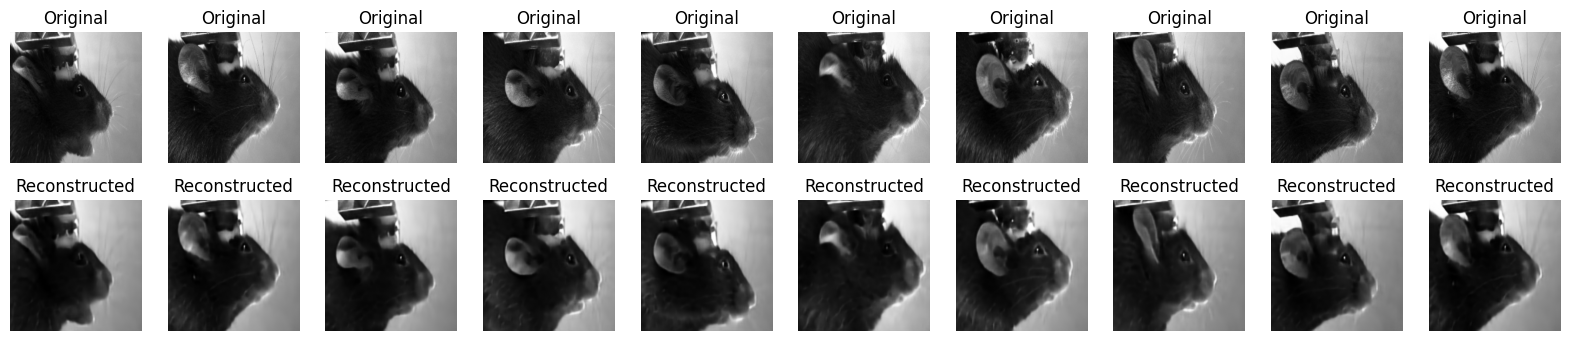

In [12]:
import matplotlib.pyplot as plt

# Predict on test data
decoded_images = autoencoder.predict(test_images)

# Plot original and reconstructed images
n = 10  # Number of images to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_images[i].reshape(224, 224), cmap='gray')
    plt.title("Original")
    plt.axis('off')
    
    # Reconstructed
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_images[i].reshape(224, 224), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')
plt.show()

In [13]:
# Create an encoder model
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer(index=3).output)  # Replace 'index=3' with the correct index for the last encoder layer
encoder.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 224, 224, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,816 (73.50 KB)

 Trainable params: 18,816 (73.50 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
import numpy as np

# Function to get latent representations in batches
def get_latent_representations(encoder, images, batch_size=32):
    batch_output_shape = encoder.predict(images[:1]).shape[1:]  # Get output shape of one example
    latent_dim = np.prod(batch_output_shape)  # Flatten to 1D
    latent_representations = np.zeros((len(images), latent_dim), dtype=np.float32)
    num_batches = int(np.ceil(len(images) / batch_size))

    for i in range(num_batches):
        start = i * batch_size
        end = min((i + 1) * batch_size, len(images))
        batch = images[start:end]
        latent_batch = encoder.predict(batch).reshape(len(batch), -1)  # Flatten output
        latent_representations[start:end] = latent_batch
    
    return latent_representations

# Get latent representations
train_latent = get_latent_representations(encoder, train_images, batch_size=16)
test_latent = get_latent_representations(encoder, test_images, batch_size=16)


# Get latent representations
#train_latent = encoder.predict(train_images)
#test_latent = encoder.predict(test_images)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


MemoryError: Unable to allocate 22.2 GiB for an array with shape (7437, 802816) and data type float32

In [13]:
print(f"Latent space representations: {test_latent.shape[0]}")  # Number of test samples
print(f"Labels: {len(test_labels)}")  # Number of labels

Latent space representations: 1860
Labels: 1860


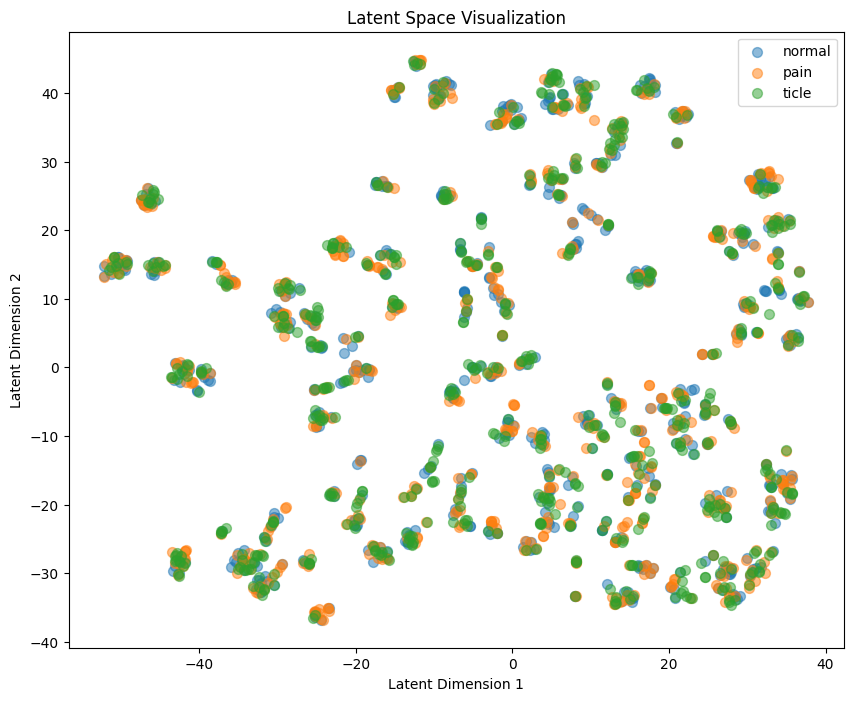

In [23]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import umap.umap_ as umap

# Reduce dimensionality to 2D using PCA or t-SNE
#pca = PCA(n_components=2)
#latent_2d = pca.fit_transform(test_latent.reshape(len(test_latent), -1))  # Flatten latent space

# Optionally use t-SNE
#tsne = TSNE(n_components=2, random_state=42, perplexity=40)
#latent_2d = tsne.fit_transform(test_latent.reshape(len(test_latent), -1))

tsne = TSNE(n_components=2, init='pca', random_state=0)
latent_2d = tsne.fit_transform(test_latent.reshape(len(test_latent), -1))
 
#plt.figure(figsize=(figsize, figsize))
#plt.scatter(X_tsne[:, 0] , X_tsne[:, 1], alpha=0.5, s=2)
#plt.show()


# Reduce dimensionality to 2D using UMAP
#umap_reducer = umap.UMAP(n_components=2, n_neighbors=200, min_dist=0.0, random_state=42)
#latent_2d = umap_reducer.fit_transform(test_latent.reshape(len(test_latent), -1))


# Plot the 2D latent space
plt.figure(figsize=(10, 8))
for stimulus, color in zip(["normal", "pain", "ticle"], ['blue', 'red', 'green']):
    indices = [i for i, label in enumerate(test_labels) if label == stimulus]
    plt.scatter(latent_2d[indices, 0], latent_2d[indices, 1], label=stimulus, alpha=0.5, s=50)

plt.legend()
plt.title("Latent Space Visualization")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.show()